# Introduction
In this notebook, i will take you through the step by step approach in solving a House Pricing regression problem. This notebook aims to:
1. Provide insights on Housing Data
2. Understand importance of Preprocessing
3. Introduction to feature engineering
4. Use of ensembling algorithm  



**V3**: Feature scaling applied to only training dataset (to avoid data leakage)  
**V4**: Added simple Hyperparameter tuning (RandomizedSearchCV)

# Table of Contents
1. [Understanding Data](#sec1)
    * [1.2 Univariate Analysis](#sec1.2)  
    * [1.3 Bi-variate Analysis](#sec1.3)  
2. [Data Preprocessing](#sec2)  
    * [2.1 Removing redundant features](#sec2.1)
    * [2.2 Dealing with Outliers](#sec2.2)
    * [2.3 Filling Missing Values](#sec2.3)
3. [Feature Engineering](#sec3)
4. [Modeling](#sec4)
    * [4.1 Scaling of features](#sec4.1)
    * [4.2 Ensemble Algorithms](#sec4.2)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer



<a id="sec1"></a>
# [1. Understanding Data](#sec1)

In [ ]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)


print("train: ", train.shape)
print("test: ", test.shape)
train.head()

train:  (1460, 80)
test:  (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
X = pd.concat([train.drop("SalePrice", axis=1),test], axis=0)
y = train[['SalePrice']]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

Lets isolate both the numerical and categorical columns since we will be applying different visualization techniques on them

In [ ]:
numeric_ = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).copy()
numeric_.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [ ]:
disc_num_var = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

cont_num_var = []
for i in numeric_.columns:
    if i not in disc_num_var:
        cont_num_var.append(i)

In [ ]:
cat_train = X.select_dtypes(include=['object']).copy()
cat_train['MSSubClass'] = X['MSSubClass']   #MSSubClass is nominal
cat_train.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

<a id="sec1.1"></a>
## [1.1 Univariate Analysis](#sec1.1)

### Numeric Features

For numerical features, we are always concerned about the **distribution** of these features, including the **statistical characteristics** of these columns e.g mean, median, mode. Hence  we will usually use **Distribution plot** to visualize their data distribution. **Boxplots** are also commonly used to unearth the statistical characteristics of each feature. More often than not, we use it to look for any outliers that we might need to filter out later on during the preprocessing step.

C:\Users\sayed\AppData\Local\Temp\ipykernel_35372\300786857.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numeric_.loc[:,col].dropna(), kde=False)


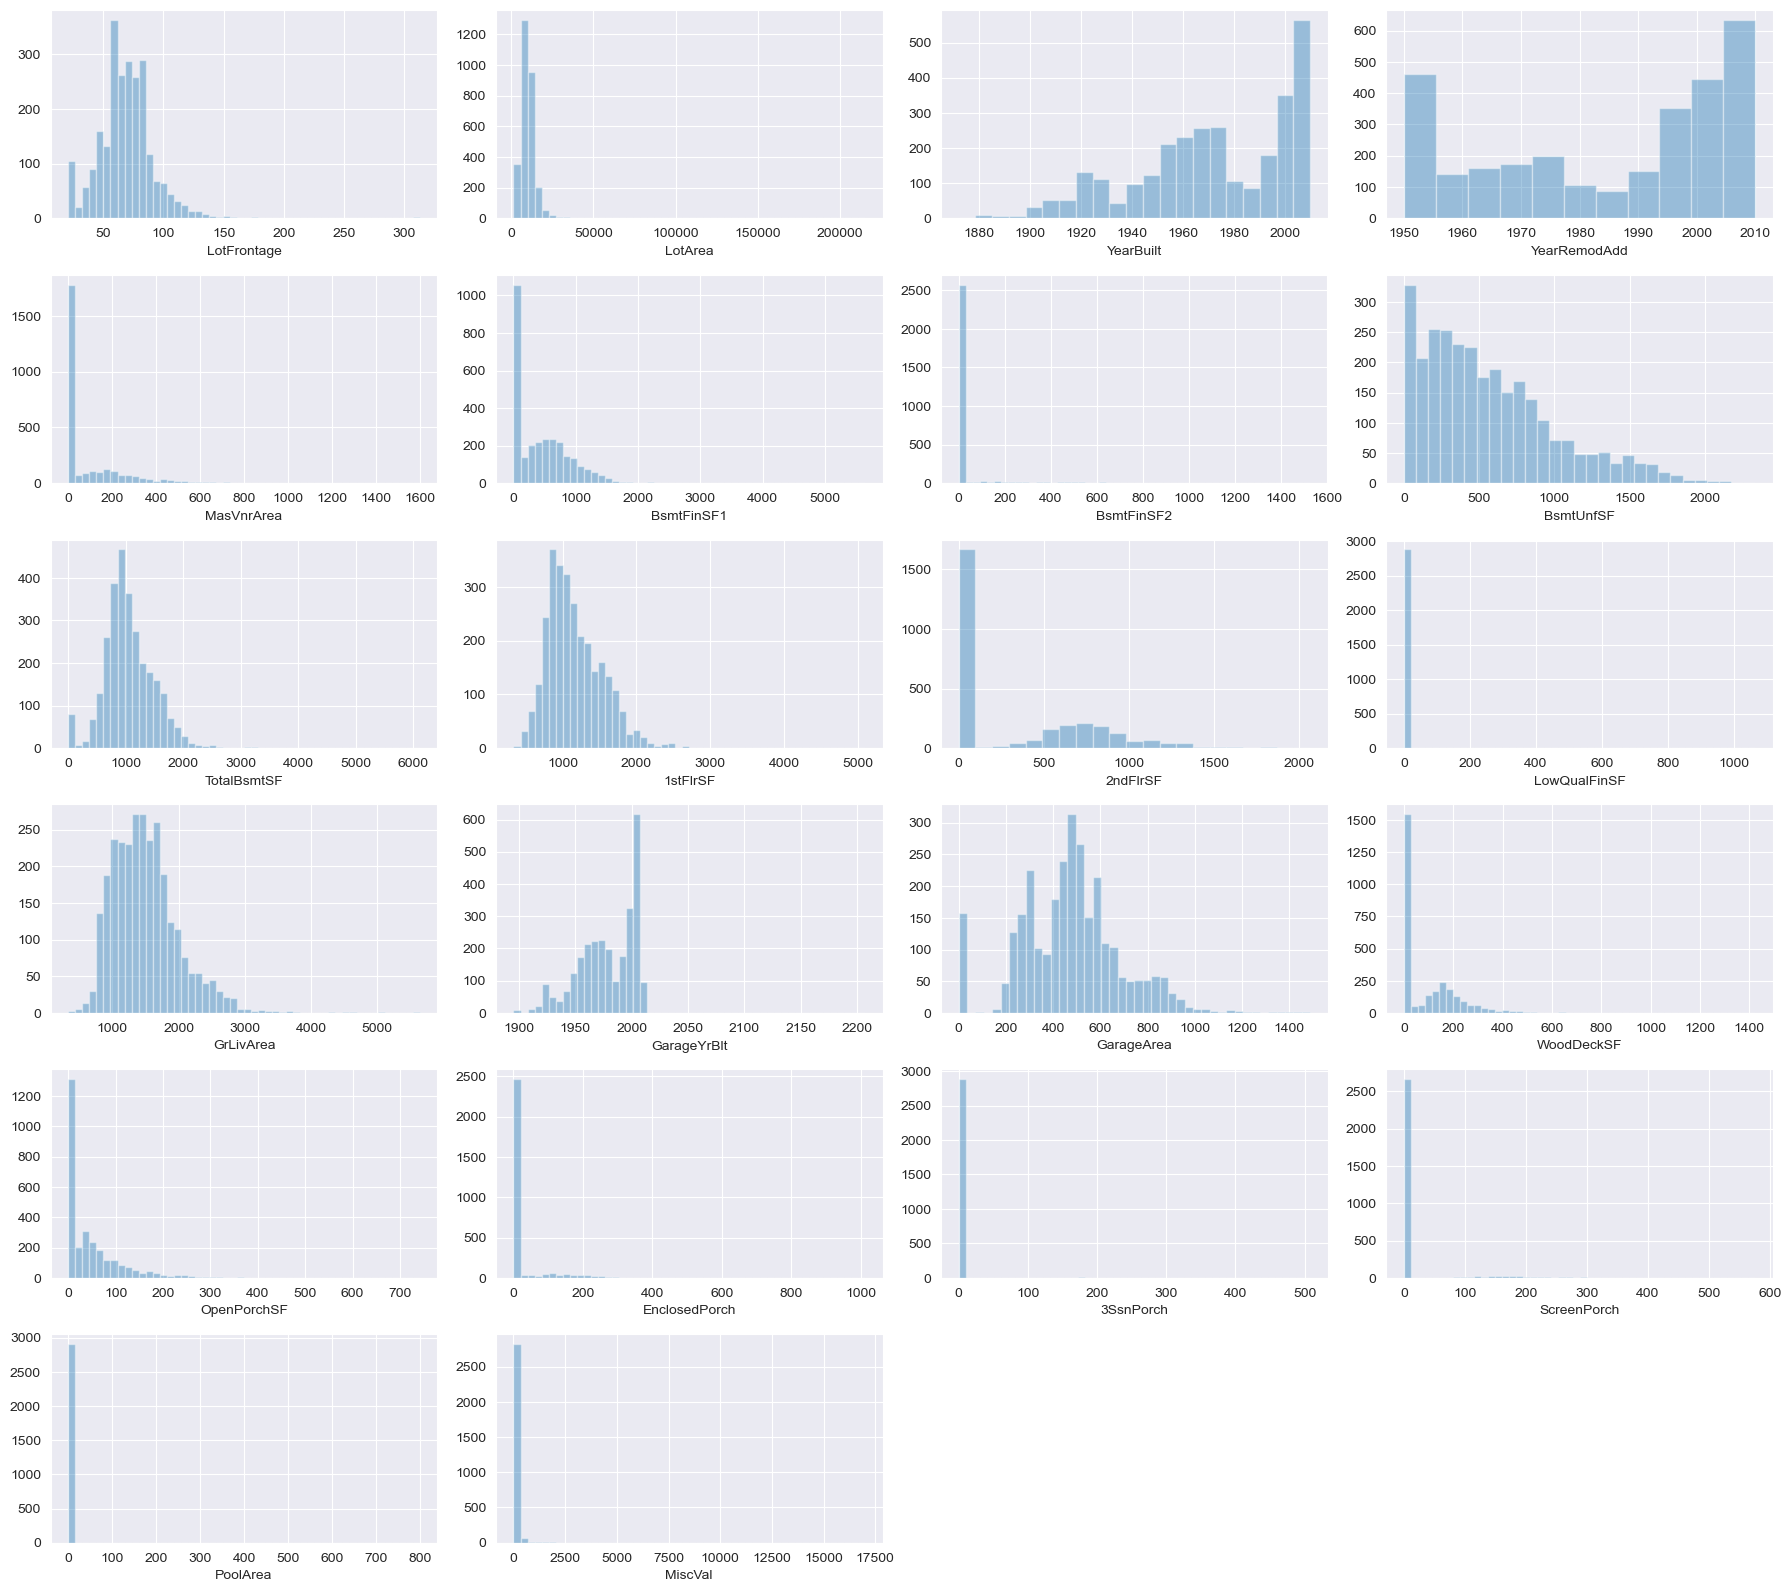

In [ ]:
fig = plt.figure(figsize=(18,16))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.distplot(numeric_.loc[:,col].dropna(), kde=False)
fig.tight_layout(pad=1.0)

Some of the Variables with mostly 1 value as seen from the plots above:
1. BsmtFinSF2
2. LowQualFinSF
3. EnclosedPorch
4. 3SsnPorch
5. ScreenPorch
6. PoolArea
7. MiscVal  

All these features are highly skewed, with mostly 0s. Having alot of 0s in the distribution doesnt really add information for predicting Housing Price. Hence, we will remove them during our preprocessing step

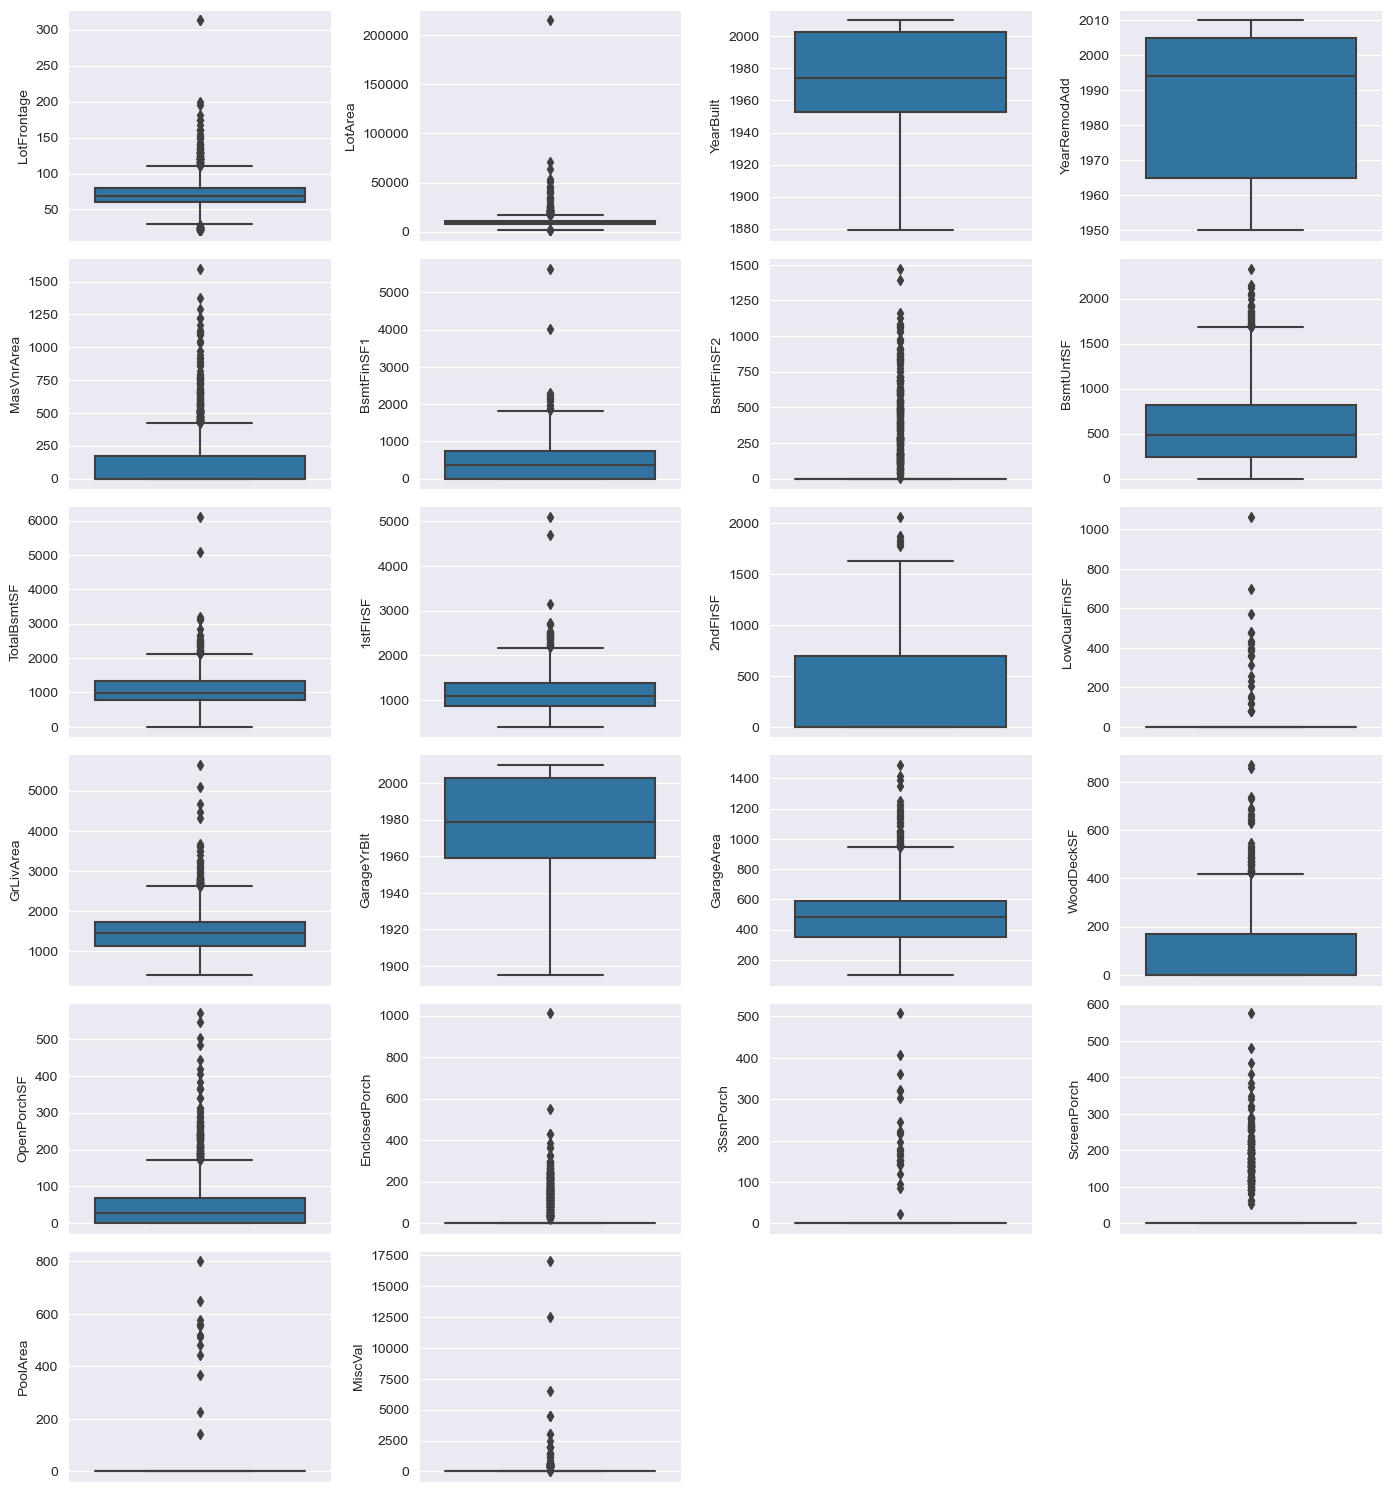

In [ ]:
fig = plt.figure(figsize=(14,15))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.boxplot(y=col, data=numeric_.dropna())
fig.tight_layout(pad=1.0)

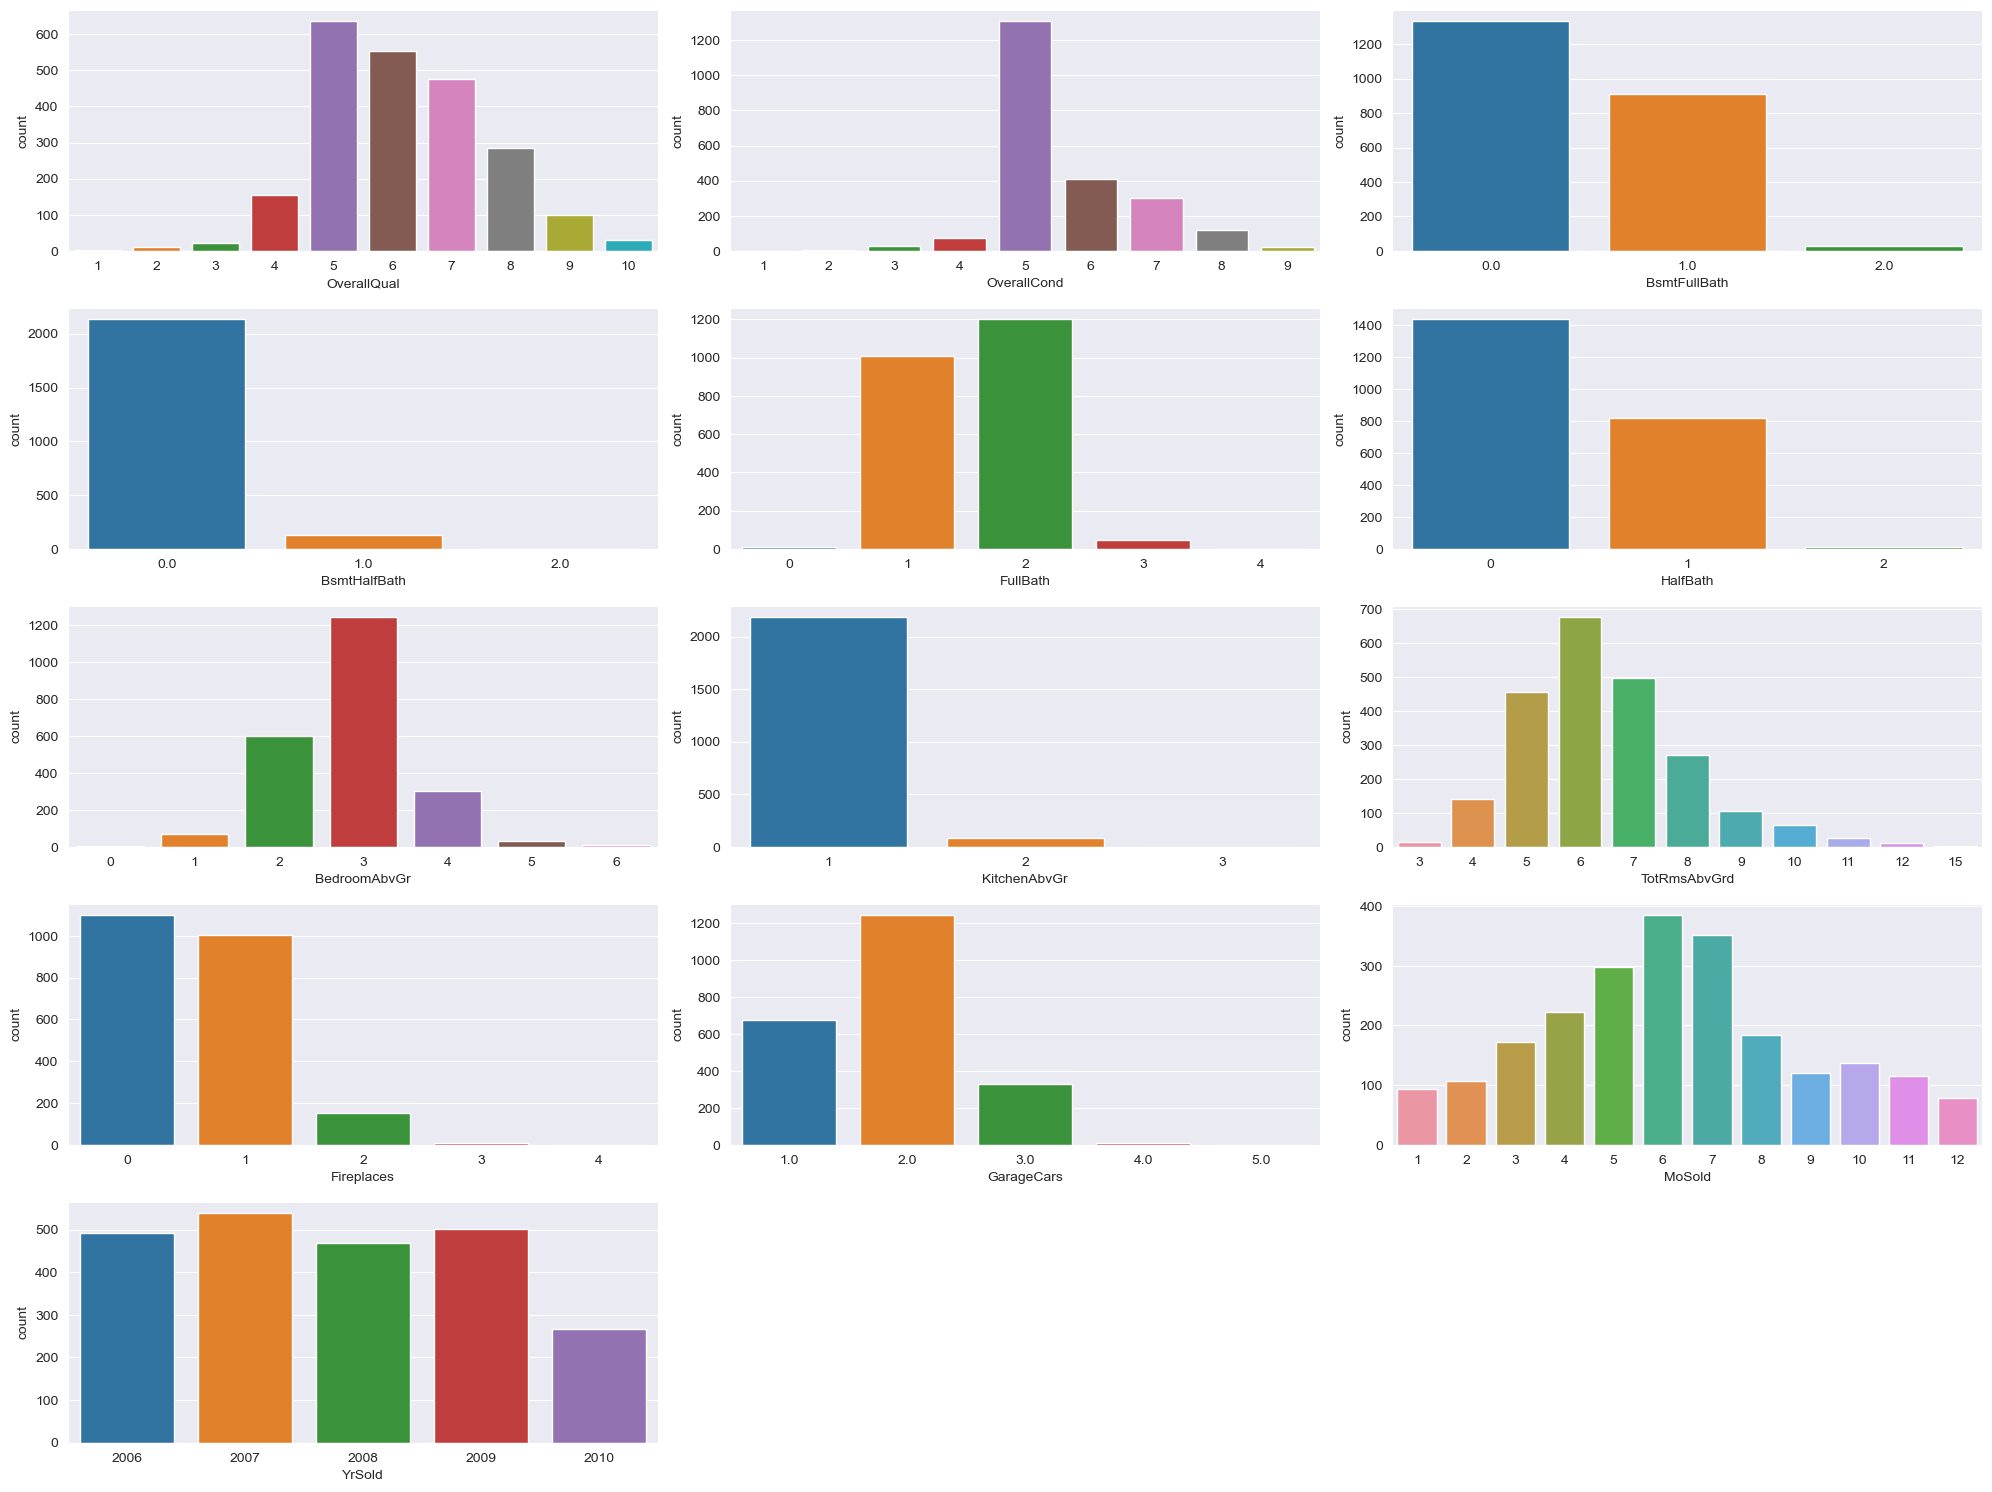

In [ ]:
fig = plt.figure(figsize=(20,15))
for index,col in enumerate(disc_num_var):
    plt.subplot(5,3,index+1)
    sns.countplot(x=col, data=numeric_.dropna())
fig.tight_layout(pad=1.0)

### Categorical Features

In the case of categorical features, we will often use countplots to visualize the count of each distinct value within each features. We can see that some categorical features like **Utilities, Condition2** consist of mainly just one value, which does not add any useful information. Thus, we will also remove them later on.

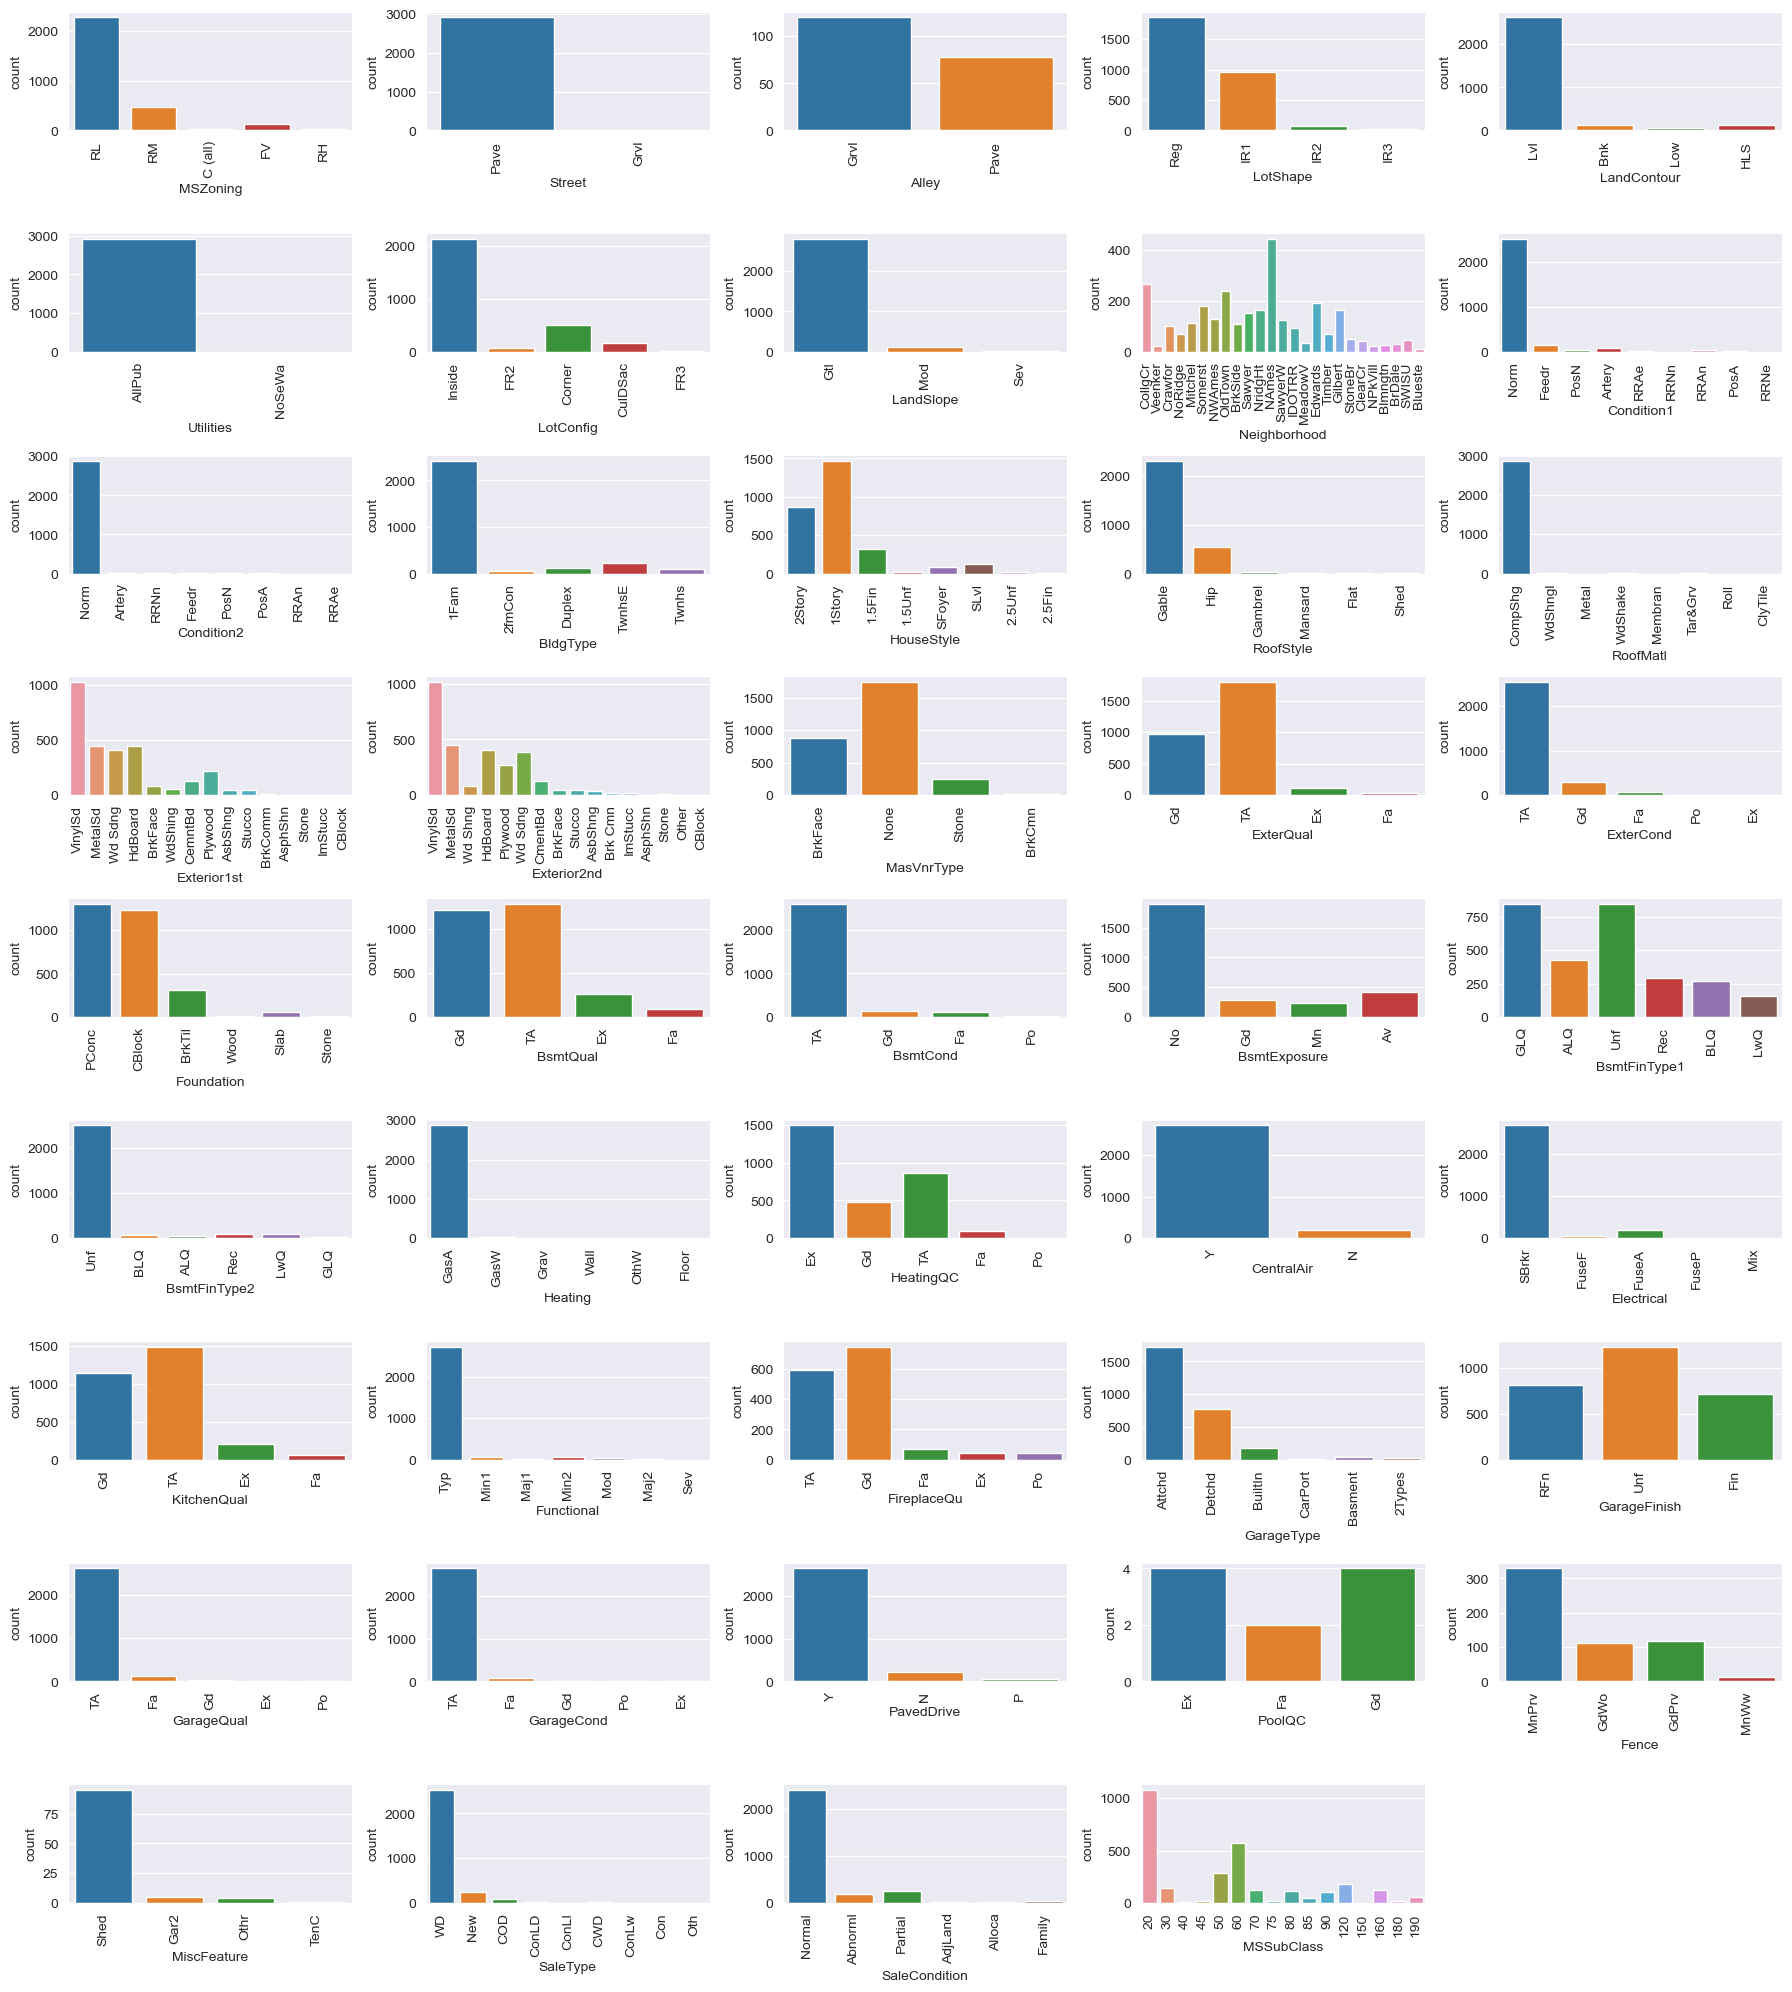

In [ ]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_train.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat_train.iloc[:,index], data=cat_train.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

Univariate Analysis helps us to understand all the features better, on an individual scale. To further deepen our insights and uncover potential pattern in the data, we will also need to find out more about the relationship between all these features with one another, which brings us to our next step in our analysis - Bivariate Analysis

<a id='sec1.2'></a>
## [1.2 Bi-Variate Analysis](#sec1.2)

Bi-variate analysis looks at 2 different features to identify any possible relationship or distinctive patterns between the 2 features. One of the commonly used technique is through the  **Correlation Matrix**. Correlation matrix is an effective tool to uncover linear relationship (Correlation) between any 2 continuous features. Correlation not only allow us to determine which features are important to Saleprice, but also as a mean to investigate any **multicollinearity** between our independent predictors.  
Multicollinearity happens when 2 or more independent variables are highly correlated with one another. In such situation, it causes precision loss in our regression coefficients, affecting our ability to identify the most important features that are most useful to our model

### Correlation Matrix

<Axes: >

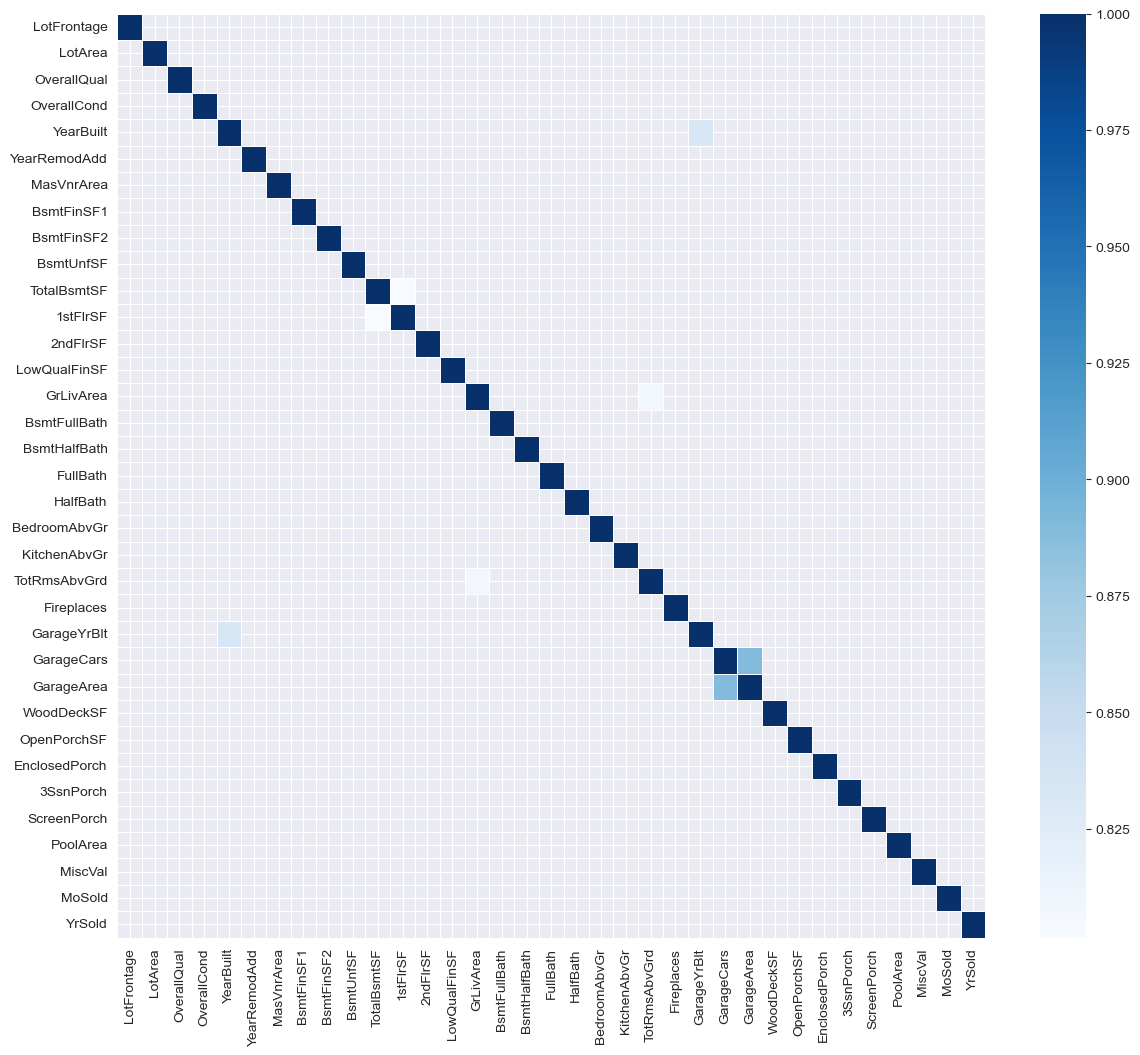

In [ ]:
plt.figure(figsize=(14,12))
correlation = numeric_.corr()
sns.heatmap(correlation, mask = correlation <0.8, linewidth=0.5, cmap='Blues')

 **Highly Correlated variables**:
* GarageYrBlt and YearBuilt
* TotRmsAbvGrd and GrLivArea
* 1stFlrSF and TotalBsmtSF
* GarageArea and GarageCars

From the correlation matrix we have identified the above variables which are highly correlated with each other. This finding will guide us in our preprocessing steps later on as we aim to remove highly correlated features to avoid performance loss in our model

### Identifying relationship between Numerical Predictor and Target (*SalePrice*)
Below, we sorted the strength of linear relationship between Saleprice and other features. OverallQual and GrLivArea has the strongest linear relationship with SalePrice. Hence, these 2 features will be important factor in predicting Housing Price

In [ ]:
numeric_train = train.select_dtypes(exclude=['object'])
correlation = numeric_train.corr()
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


### Scatterplot
Using scatterplot can also help us to identify potential linear relationship between Numerical features. Although scatterplot does not provide quantitative evidence on the strength of linear relationship between our features, it is useful in helping us to visualize any sort of relationship that correlation matrix could not calculate. E.g Quadratic, Exponential relationships.

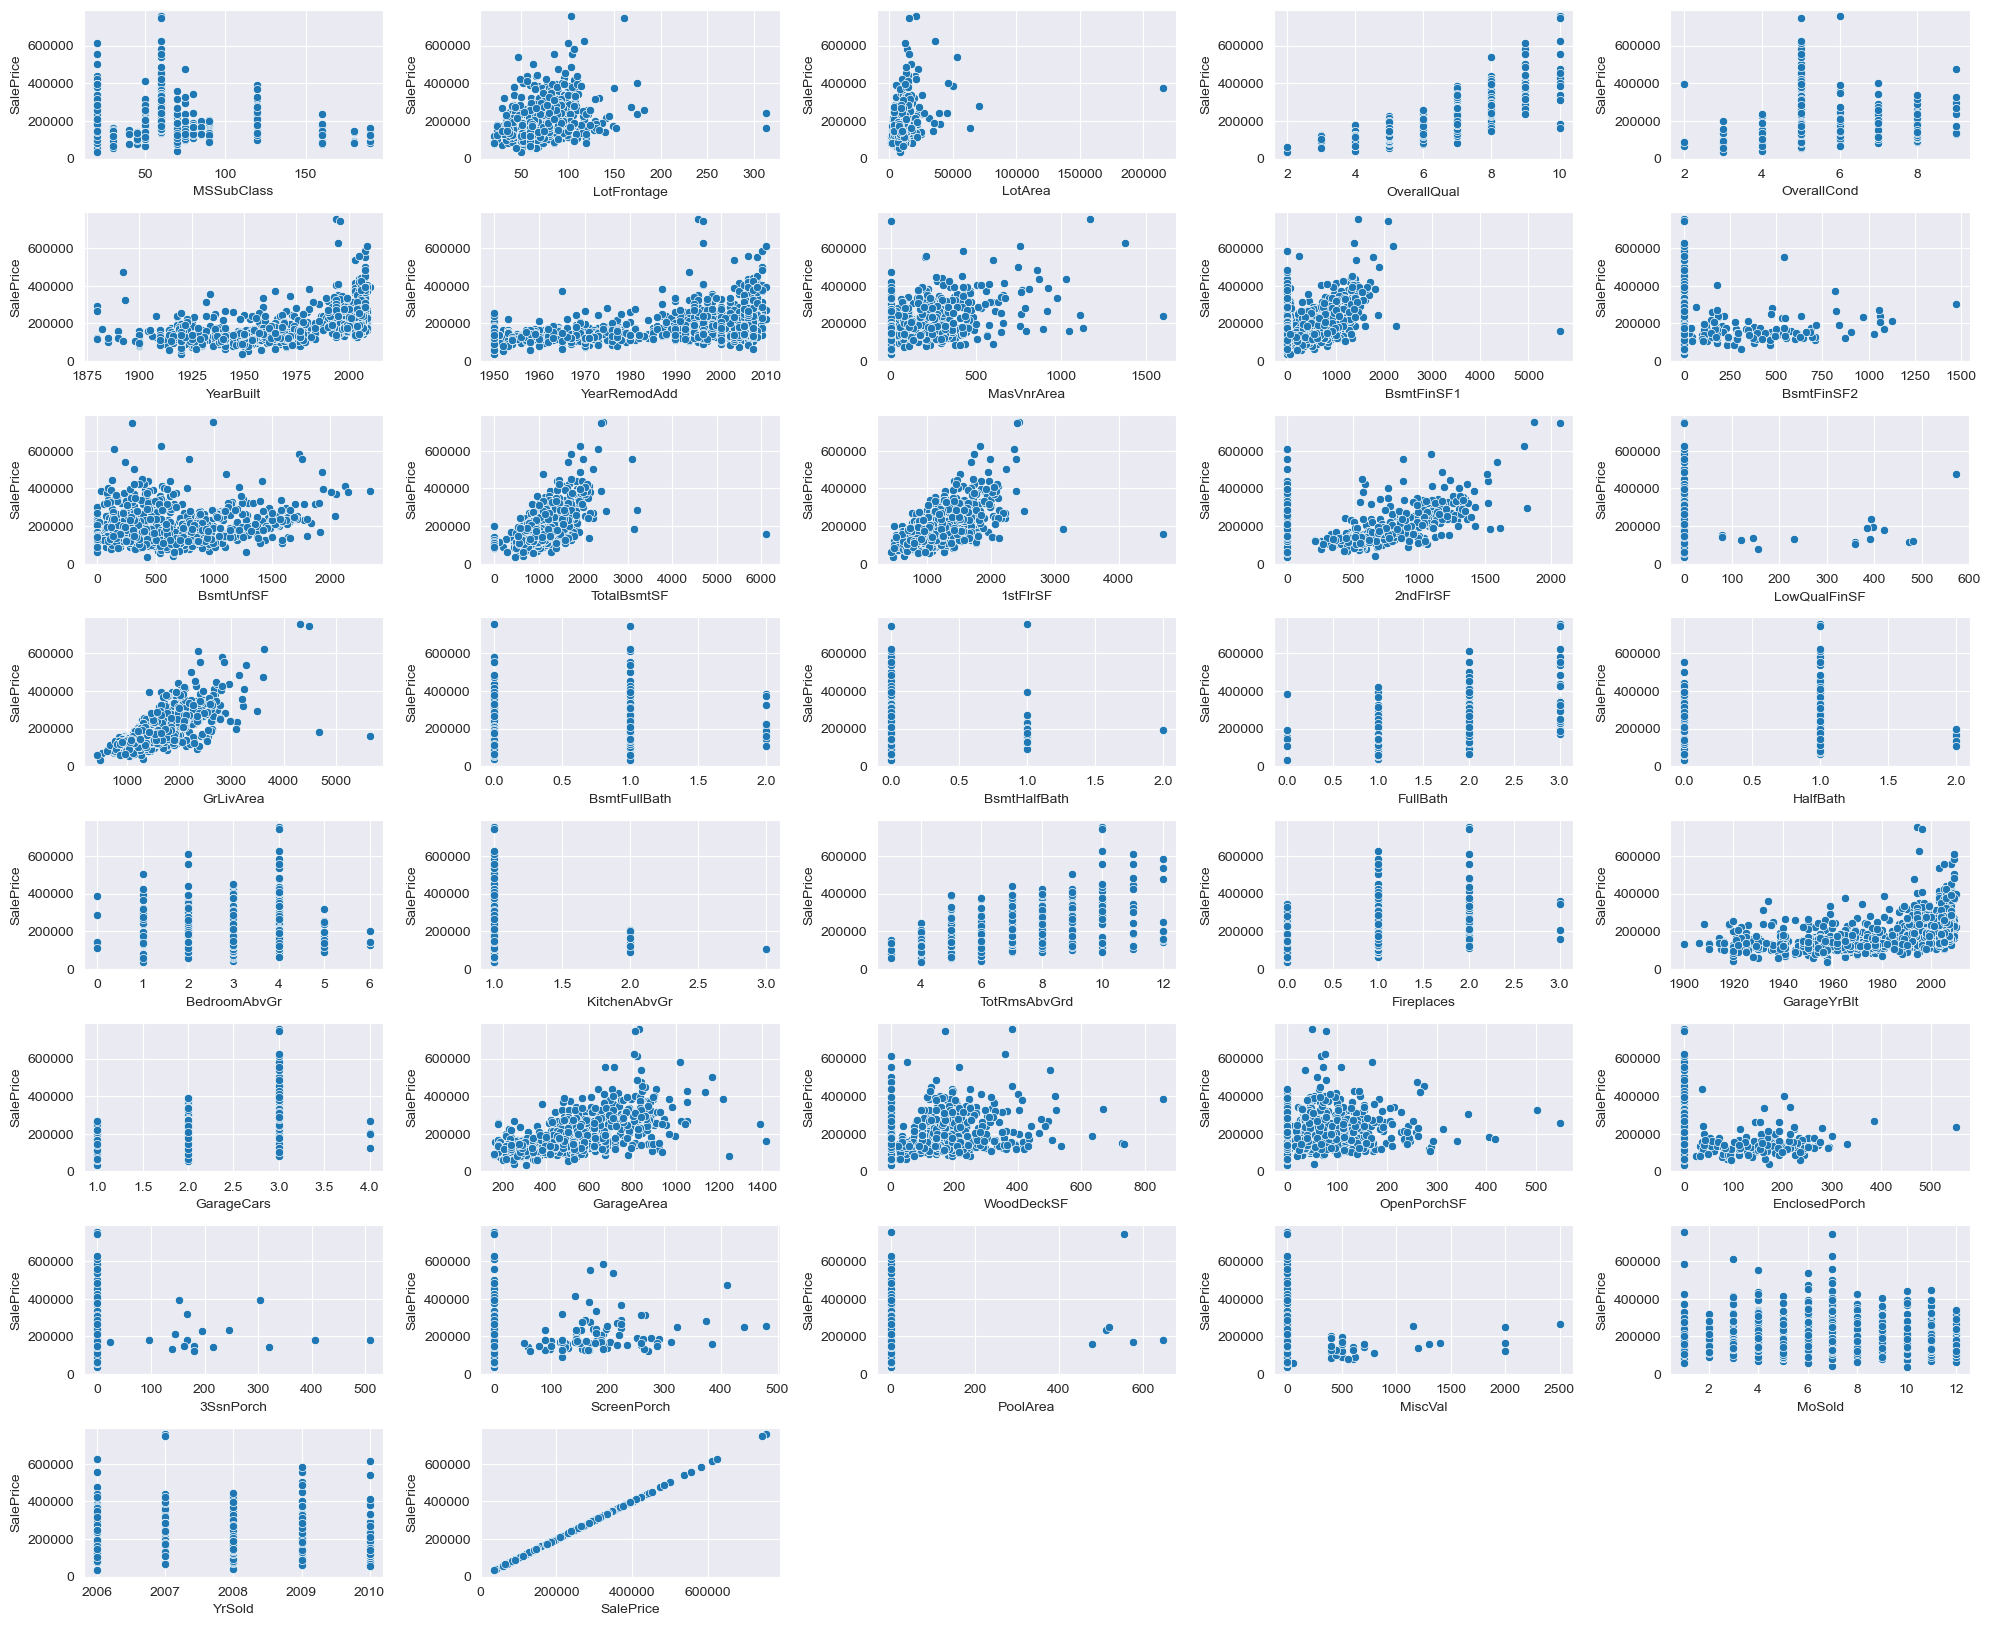

In [ ]:
fig = plt.figure(figsize=(20,20))
for index in range(len(numeric_train.columns)):
    plt.subplot(10,5,index+1)
    sns.scatterplot(x=numeric_train.iloc[:,index], y='SalePrice', data=numeric_train.dropna())
fig.tight_layout(pad=1.0)

<a id = 'sec2'></a>
# [2. Data Processing](#sec2)

Now that we have more or less finished analysing our data and gaining insights through the various analysis and visualization, we will have to leverage on these insights to guide our preprocessing decision, so as to provide a clean and error-free data for our model to train on later on.  

We do not perform visualization and analysis just to create pretty graphs or for the sake of doing it, IT IS VITAL TO OUR PREPROCESSING!

This section outlines the steps for Data Processing:
1. Removing Redundant Features
2. Dealing with Outliers
3. Filling in missing values

<a id="sec2.1"></a>
## [2.1 Removing Redundant Features](#sec2.1)

### Features with multicollinearity

From the above correlation matrix, we have pinpointed certain features that are highly correlated
* GarageYrBlt and YearBuilt
* TotRmsAbvGrd and GrLivArea
* 1stFlrSF and TotalBsmtSF
* GarageArea and GarageCars

We will remove the highly correlated features to avoid the problem of multicollinearity explained earlier

In [ ]:
X.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1, inplace=True)

### Features with alot of missing values
Apart from these highly correlated features, we will also remove features that is not very useful in prediction due to many missing values. PoolQC, MiscFeature, Alley has too many missing values to provide any useful information

<Axes: title={'center': 'Number of missing rows'}, xlabel='features', ylabel='sum'>

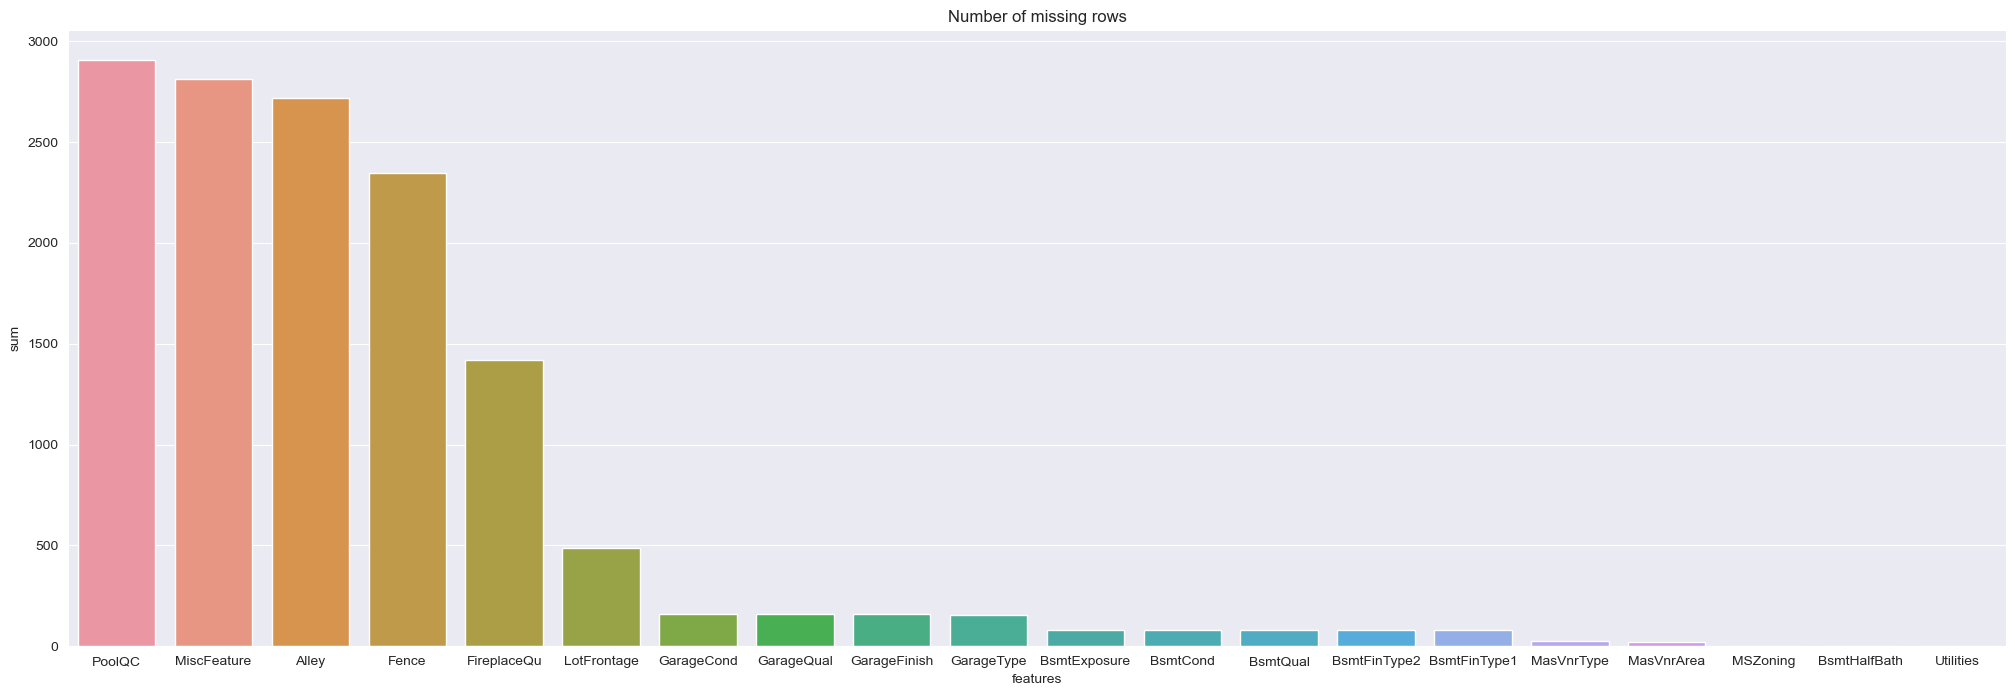

In [ ]:
plt.figure(figsize=(25,8))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features','sum']
sns.barplot(x='features',y='sum', data = missing_count)

In [ ]:
X.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)

### Useless features in predicting SalePrice
We will also remove features that does not have any linear relationship with target *SalePrice*. We can see from the plot below that the MoSold and YrSold does not have any impact on the price of the house sold.

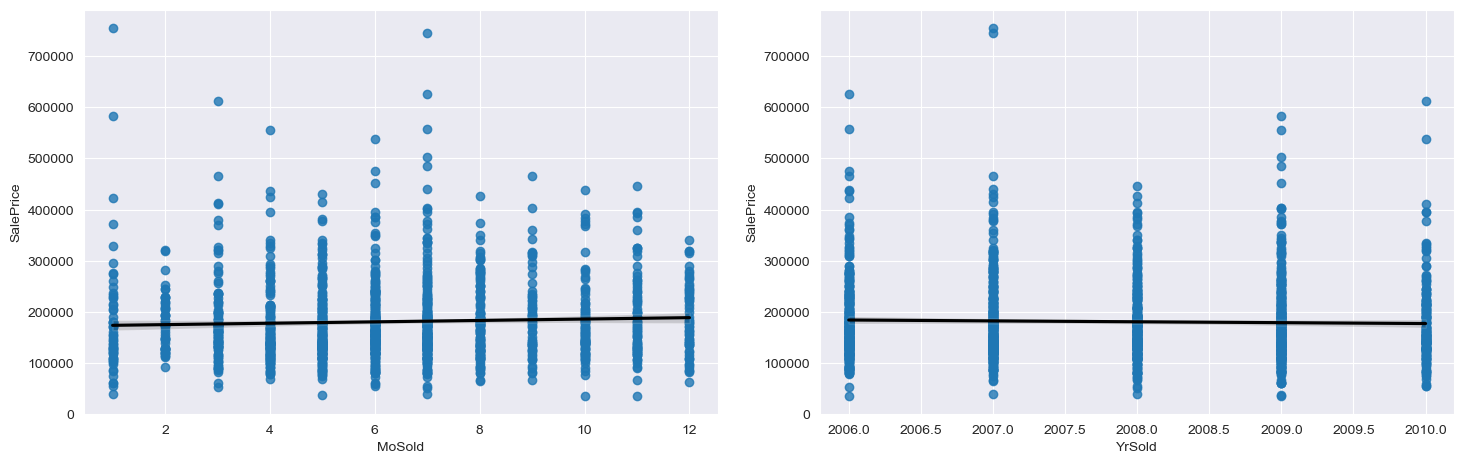

In [ ]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.regplot(x=numeric_train['MoSold'], y='SalePrice', data=numeric_train, ax = axes[0], line_kws={'color':'black'})
sns.regplot(x=numeric_train['YrSold'], y='SalePrice', data=numeric_train, ax = axes[1],line_kws={'color':'black'})
fig.tight_layout(pad=2.0)

In [ ]:
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False).tail(10)

X.drop(['MoSold','YrSold'], axis=1, inplace=True)

### Removing features that have mostly just 1 value

Earlier during our Univariate analysis, we found that some features mostly consist of just a single value or 0s, which is not useful to us. Therefore, we set a user defined threshold at 96%. If a column has more than 96% of the same value, we will render the features to be useless and remove it, since there isnt much information we can extract from

In [ ]:
cat_col = X.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
X = X.drop(overfit_cat, axis=1)

In [ ]:
num_col = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).columns
overfit_num = []
for i in num_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_num.append(i)

overfit_num = list(overfit_num)
X = X.drop(overfit_num, axis=1)

In [ ]:
print("Categorical Features with >96% of the same value: ",overfit_cat)
print("Numerical Features with >96% of the same value: ",overfit_num)

Categorical Features with >96% of the same value:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
Numerical Features with >96% of the same value:  ['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal']


<a id="sec2.2"></a>
## [2.2 Dealing with Outliers](#sec2.2)

Removing outliers will prevent our models performance from being affected by extreme values.  
From our boxplot earlier, we have pinpointed the following features with extreme outliers:
* LotFrontage
* LotArea
* BsmtFinSF1
* TotalBsmtSF
* GrLivArea

We will remove the outliers based on certain threshold value.

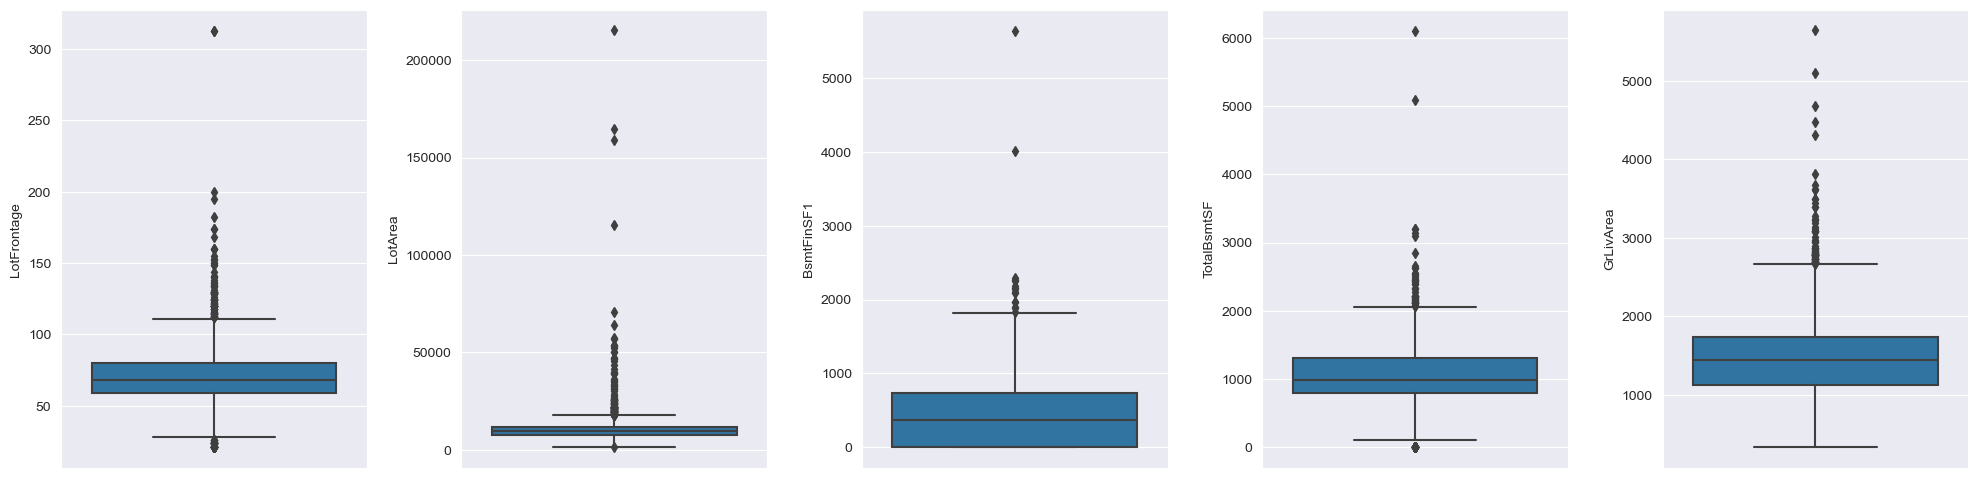

In [ ]:
out_col = ['LotFrontage','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea']
fig = plt.figure(figsize=(20,5))
for index,col in enumerate(out_col):
    plt.subplot(1,5,index+1)
    sns.boxplot(y=col, data=X)
fig.tight_layout(pad=1.5)

In [ ]:
train = train.drop(train[train['LotFrontage'] > 200].index)
train = train.drop(train[train['LotArea'] > 100000].index)
train = train.drop(train[train['BsmtFinSF1'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF'] > 5000].index)
train = train.drop(train[train['GrLivArea'] > 4000].index)

In [ ]:
X.shape

(2919, 61)

<a id="sec2.3"></a>
## [2.3 Filling Missing Values](#sec2.3)

Our machine learning model is unable to deal with missing values, thus we need to deal with them based on our understanding of the features. These missing values are denoted **NAN** as we have seen earlier during our data exploration.

In [ ]:
pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(15)

,sum
Fence,2348
FireplaceQu,1420
LotFrontage,486
GarageFinish,159
GarageCond,159
GarageQual,159
GarageType,157
BsmtCond,82
BsmtExposure,82
BsmtQual,81


### Ordinal features
We will replace the ordinal missing values with NA, which will be mapped later on when we encode them into an ordered arrangement

In [ ]:
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1',
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu','Fence',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']

X[cat] = X[cat].fillna("NA")

### Categorical features
We will replace the missing value of our categorical features with the most frequent occurrence (mode) of the individual features.

In [ ]:
#categorical
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))

### Numerical features
For **Numerical Features**, the common approach will be to replace the missing value with the mean of the feature distribution.  
However, certain features like *LotFrontage* and *GarageArea* have wide variance in their distribution. Taking mean values across *Neighborhoods*, we will see that the mean varies alot from just taking the mean value of these individual column, since each neightborhood have different LotFrontage and GarageArea mean value. Hence, i decided to group these features by Neighborhoods to impute the respective mean values.

**Note**: My initial approach was based on the means of both train and test set. This exposed us to the issue of data leakage, where information from the test set is used to compute mean values. The right way to do it will be to impute solely based on the mean of the train data.

In [ ]:
print("Mean of LotFrontage: ", X['LotFrontage'].mean())
print("Mean of GarageArea: ", X['GarageArea'].mean())

Mean of LotFrontage:  69.30579531442663
Mean of GarageArea:  472.8745716244003


<Axes: xlabel='Neighborhood', ylabel='GarageArea_mean'>

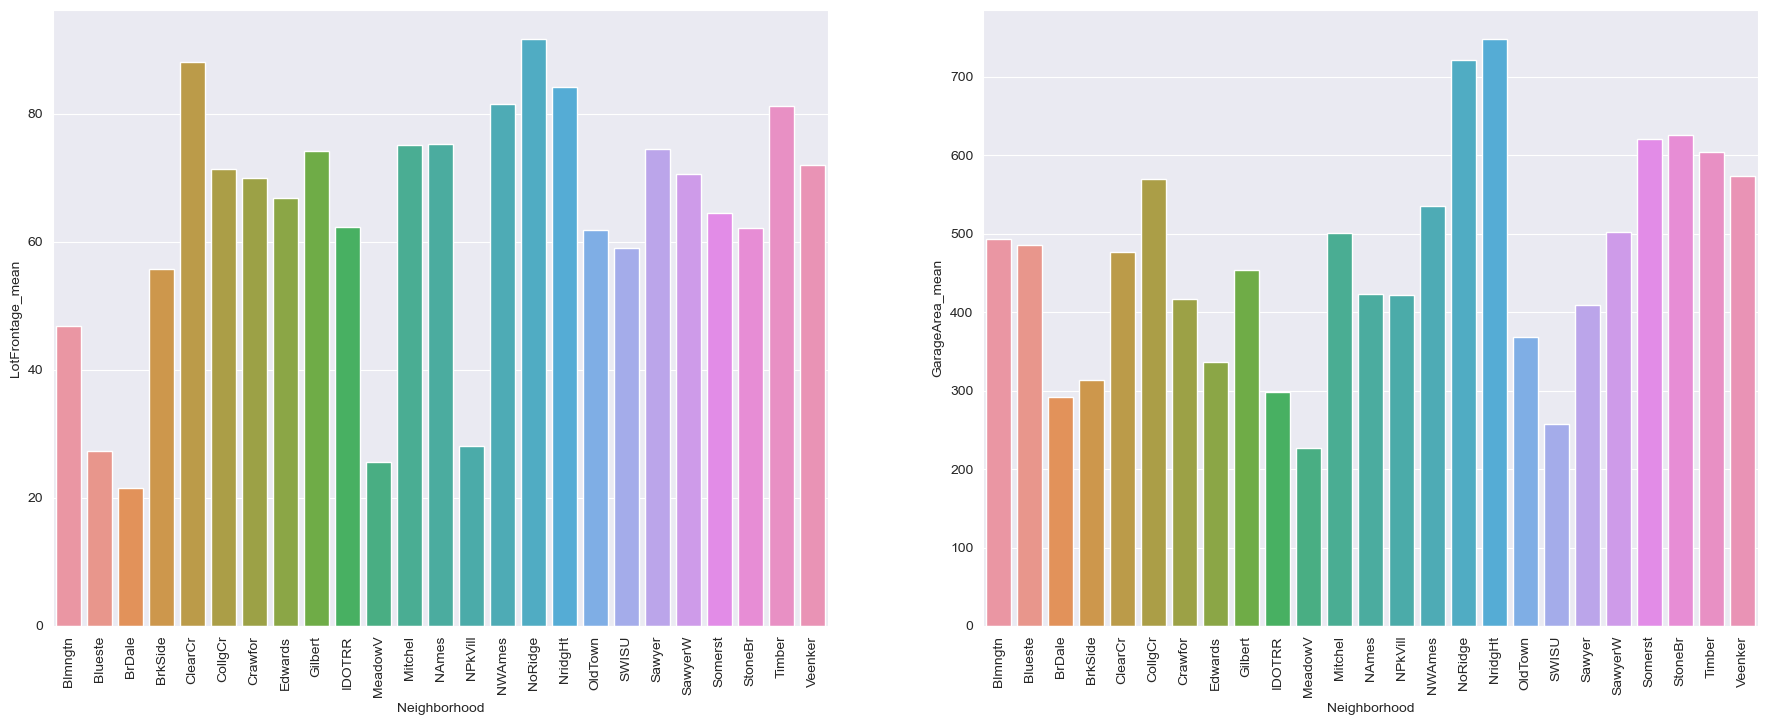

In [ ]:
neigh_lot = X.groupby('Neighborhood')['LotFrontage'].mean().reset_index(name='LotFrontage_mean')
neigh_garage = X.groupby('Neighborhood')['GarageArea'].mean().reset_index(name='GarageArea_mean')

fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])

In [ ]:
#for correlated relationship
X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
X['GarageArea'] = X.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))
X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

#numerical
cont = ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]
X[cont] = X[cont] = X[cont].fillna(X[cont].mean())

#### Changing Data Type
Since **MSSubClass** is an integer column based on some mapped values in string notation, we change its data type to string value instead

In [ ]:
X['MSSubClass'] = X['MSSubClass'].apply(str)

### Mapping Ordinal Features
There are some columns which are ordinal by nature, which represents the quality or condition of certain housing features. In this case, we will map the respective strings to a value. The better the quality, the higher the value

In [ ]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [ ]:
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    X[col] = X[col].map(ordinal_map)

fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    X[col] = X[col].map(fintype_map)

X['BsmtExposure'] = X['BsmtExposure'].map(expose_map)
X['Fence'] = X['Fence'].map(fence_map)

After removing the outliers, highly correlated features and imputing missing values, we can now proceed with adding additional information for our model to train on. This is done by the means of - Feature Engineering.

<a id='sec3'><a>
# [3. Feature Engineering](#sec3)
Feature Engineering is a technique by which we create new features that could potentially aid in predicting our target variable, which in this case, is *SalePrice*. In this notebook, we will create additional features based on our **Domain Knowledge** of the housing features

Based on the current feature we have, the first additional featuire we can add would be **TotalLot**, which sums up both the *LotFrontage* and *LotArea* to identify the total area of land available as lot. We can also calculate the total number of surface area of the house, **TotalSF** by adding the area from basement and 2nd floor. **TotalBath** can also be used to tell us in total how many bathrooms are there in the house. We can also add all the different types of porches around the house and generalise into a total porch area, **TotalPorch**.  
* TotalLot = LotFrontage + LotArea
* TotalSF = TotalBsmtSF + 2ndFlrSF
* TotalBath = FullBath + HalfBath
* TotalPorch = OpenPorchSF + EnclosedPorch + ScreenPorch
* TotalBsmtFin = BsmtFinSF1 + BsmtFinSF2

In [ ]:
X['TotalLot'] = X['LotFrontage'] + X['LotArea']
X['TotalBsmtFin'] = X['BsmtFinSF1'] + X['BsmtFinSF2']
X['TotalSF'] = X['TotalBsmtSF'] + X['2ndFlrSF']
X['TotalBath'] = X['FullBath'] + X['HalfBath']
X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['ScreenPorch']

### Binay Columns
We also include simple feature engineering by creating binary columns for some features that can indicate the **presence(1) / absence(0)** of some features of the house

In [ ]:
colum = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','2ndFlrSF','WoodDeckSF','TotalPorch']

for col in colum:
    col_name = col+'_bin'
    X[col_name] = X[col].apply(lambda x: 1 if x > 0 else 0)

### Converting Categorical to Numerical
Lastly, because machine learning only learns from data that is numerical in nature, we will convert the remaining categorical columns into one-hot features using the *get_dummies()* method into numerical columns that is suitable for feeding into our machine learning algorithm.

In [ ]:
X = pd.get_dummies(X)

### SalePrice Distribution

C:\Users\sayed\AppData\Local\Temp\ipykernel_35372\3242858411.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  dist = sns.distplot(train['SalePrice'],norm_hist=False)


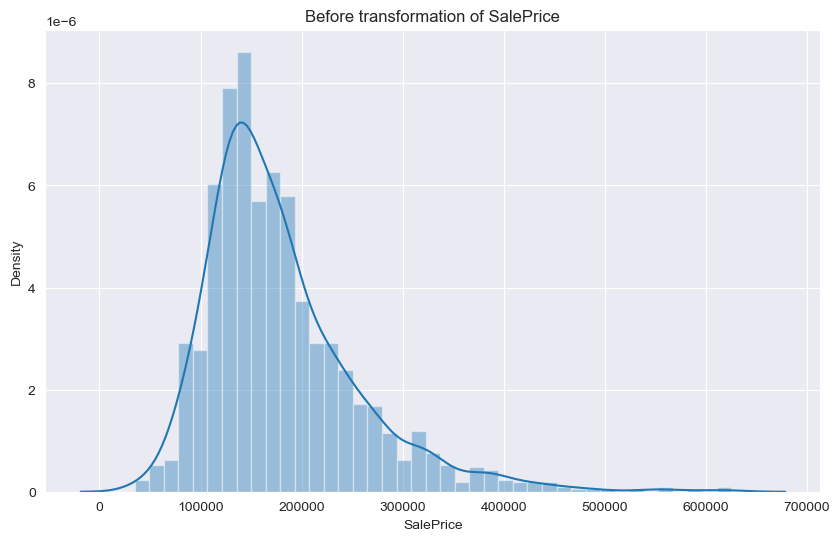

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Before transformation of SalePrice")
dist = sns.distplot(train['SalePrice'],norm_hist=False)

Distribution is skewed to the right, where the tail on the curve’s right-hand side is longer than the tail on the left-hand side, and the mean is greater than the mode. This situation is also called positive skewness.  
Having a skewed target will affect the overall performance of our machine learning model, thus, one way to alleviate will be to using **log transformation** on skewed target, in our case, the *SalePrice* to reduce the skewness of the distribution.

C:\Users\sayed\AppData\Local\Temp\ipykernel_35372\1692972096.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  dist = sns.distplot(np.log(train['SalePrice']),norm_hist=False)


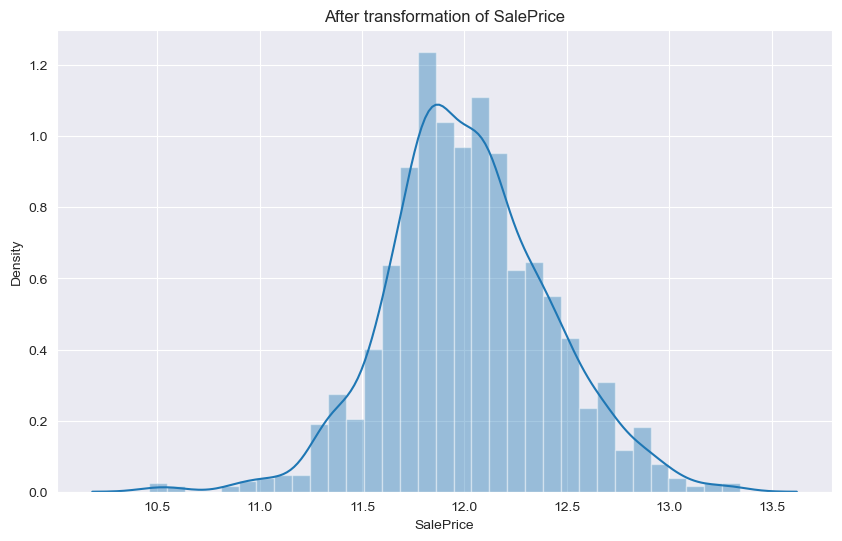

In [ ]:
plt.figure(figsize=(10,6))
plt.title("After transformation of SalePrice")
dist = sns.distplot(np.log(train['SalePrice']),norm_hist=False)

In [ ]:
y["SalePrice"] = np.log(y['SalePrice'])

Now that we are satisfied with our final data, we will proceed to the part where we will solve this regression problem - Modeling

<a id='sec4'></a>
# [4. Modeling](#sec4)
This section will consist of scaling the data for better optimization in our training, and also introducing the varieties of ensembling methods that are used in this notebook for predicting the Housing price. We also try out hyperparameter tuning briefly, as i will be dedicating a new notebook that will explain more in details on the process of Hyperparameter Tuning as well as the mathematical aspect of the ensemble algorithms.

### Split into train-validation set

In [ ]:
x = X.loc[train.index]
y = y.loc[train.index]
test = X.loc[test.index]

<a id='sec4.1'></a>
## [4.1 Scaling of Data](#sec4.1)
**RobustScaler** is a transformation technique that removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). It is also robust to outliers, which makes it ideal for data where there are too many outliers that will drastically reduce the number of training data.

Previously i fitted the RobustScaler on both Train and Test set, and that is a mistake on my side. By fitting the scaler on both train and testset, we exposed ourselves to the problem of **Data Leakage**. Data Leakage is a problem when information from outside the training dataset is used to create the model. If we fit the scaler on both training and test data, our training data characteristics will contain the distribution of our testset. As such, we are unknowningly passing in information about our test data into the final training data for training, which will not give us the opportunity to truly test our model on data it has never seen before.  
**Lesson Learnt**: Fit the scaler just on training data, and then transforming it on both training and test data

In [ ]:
from sklearn.preprocessing import RobustScaler

cols = x.select_dtypes(np.number).columns
transformer = RobustScaler().fit(x[cols])
x[cols] = transformer.transform(x[cols])
test[cols] = transformer.transform(test[cols])

<a id='sec4.2'></a>
## [4.2 Ensemble Algorithms](#sec4.2)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=2020)

### Ensembling Models
Ensembling methods are meta-algorithms which involves combining several machine learning models into one predictive model, aim at decreasing variance(reduce overfitting) and improving bias(improve accuracy).  
The 2 main ensembling methods are **Bagging, Boosting**.  


**Boosting** works on a class of weak learners, improving them into strong learners. It is being improved sequentially where the misclassified instances will be given more weights so that during the subsequent training, the learner will place more emphasis in correcting the previously misclassfied instance, less so on the already correctly identified instances.
Over time, the eventual learner will possess the ability to predict accurately as a result of learning from past mistakes
![](https://cdn-images-1.medium.com/max/1000/1*Rc8zmJUYZU0tq3wrCKuUNg.png)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
gb = GradientBoostingRegressor()

#### Gradinet Boosting HyperParameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 500, ],
    'max_depth' : [3, 6, 9],

}

gb_reg = RandomizedSearchCV(estimator = gb, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)

gb_search = gb_reg.fit(X_train, y_train)

# XGB with tune hyperparameters
best_param = xgb_search.best_params_
gb = GradientBoostingRegressor(**best_param)

### Random Forest


In [ ]:
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor()

#### Random Forest Hyperparameter tuning

In [ ]:
param_lst = {
    'max_depth' : [2, 5, 8, 10],
    'min_samples_split' : [5,7,9],
    'n_estimators' : [10,50,100],
}

RFRRand = RandomizedSearchCV(estimator = RFR, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)

RFRRand_search = RFRRand.fit(X_train, y_train)

# Random Forest with tuned hyperparameters
best_param = RFRRand_search.best_params_
RFR = RandomForestRegressor(**best_param)

#### Training and Evaluation

In [ ]:
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean



gb.fit(X_train, y_train)
preds = gb.predict(X_val)
preds_test_gb = gb.predict(test)
mae_gb = mean_absolute_error(y_val, preds)
rmse_gb = np.sqrt(mean_squared_error(y_val, preds))
score_gb = gb.score(X_val, y_val)
cv_gb = mean_cross_val(gb, x, y)


RFR.fit(X_train, y_train)
preds = RFR.predict(X_val)
preds_test_RFR = RFR.predict(test)
mae_RFR = mean_absolute_error(y_val, preds)
rmse_RFR= np.sqrt(mean_squared_error(y_val, preds))
score_RFR = RFR.score(X_val, y_val)
cv_RFR = mean_cross_val(RFR, x, y)

C:\Users\sayed\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sayed\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sayed\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sayed\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [ ]:
model_performances = pd.DataFrame({
    "Model" : ["Gradient Boost", "Random Fores "],
    "CV(5)" : [str(cv_gb)[0:5], str(cv_RFR)[0:5]],
    "MAE" : [str(mae_gb)[0:5], str(mae_RFR)[0:5]],
    "RMSE" : [str(rmse_gb)[0:5], str(rmse_RFR)[0:5]],
    "Score" : [str(score_gb)[0:5], str(score_RFR)[0:5]]
})

print("Sorted by Score:")
print(model_performances.sort_values(by="Score", ascending=False))

Sorted by Score:
            Model  CV(5)    MAE   RMSE  Score
0  Gradient Boost  0.904  0.079  0.110  0.917
1   Random Fores   0.653  0.156  0.208  0.707


### Thanks

Some of the references that i took from:  
https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/  
https://medium.com/cracking-the-data-science-interview/the-10-statistical-techniques-data-scientists-need-to-master-1ef6dbd531f7
